In [1]:
# Printing CPU infos (CPU allocated : Tesla p-100)
!nvidia-smi

Thu Jun 10 08:57:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import pandas as pd
import seaborn as sns
import os
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator

In [3]:
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function to save figures
def save_fig(fig_id, tight_layout=True, fig_extension="jpg", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [4]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# Part 1 - Import Dataset

In [5]:
# Import the dataset from the input folder
df = pd.read_csv('../input/dog-breed-identification/labels.csv')

In [6]:
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Let's add a new column in this dataframe with the path of each dog image.


In [7]:
# Path to the train folder containing all the images
IMG_TRAIN_PATH = "/kaggle/input/dog-breed-identification/train/"

# Path to the test folder containing all the test images
IMG_TEST_PATH = "/kaggle/input/dog-breed-identification/test/"

# Creating the new dataframe column "img_path"
df = df.assign(img_path = lambda x: IMG_TRAIN_PATH + x['id'] + '.jpg')

In [8]:
df.head()

,id,breed,img_path
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,/kaggle/input/dog-breed-identification/train/0...
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,/kaggle/input/dog-breed-identification/train/0...
2,001cdf01b096e06d78e9e5112d419397,pekinese,/kaggle/input/dog-breed-identification/train/0...
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,/kaggle/input/dog-breed-identification/train/0...
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,/kaggle/input/dog-breed-identification/train/0...


# Part 2 - Image preprocessing (Data augmentation)

## Preprocessing the training set

In [9]:
# Applying transformation to all the images of the training set to avoid overfitting
train_datagen = ImageDataGenerator(
    rescale = 1./255, # rescaling factor. Defaults to None. If None or 0, no rescaling is applied 
    shear_range = 0.2, # Float. Shear Intensity (Shear angle in counter-clockwise direction in degrees)
    zoom_range = 0.2, # Float or [lower, upper]. Range for random zoom.
    horizontal_flip = True, # Boolean. Randomly flip inputs vertically.
    validation_split = 0.25
)

## Preprocessing the testing set

In [10]:
test_datagen = ImageDataGenerator(
    rescale = 1./255
)

# Part 3 - Splitting the dataset into the training set and the testing set

In [11]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df,
    directory="../input/dog-breed-identification/",
    x_col="img_path",
    y_col="breed",
    subset="training",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory="../input/dog-breed-identification/",
    x_col="img_path",
    y_col="breed",
    subset="validation",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224,224)
)

Found 7667 validated image filenames belonging to 120 classes.
Found 2555 validated image filenames belonging to 120 classes.


# Part 4 - Neural network model

In [12]:
base_model = keras.applications.xception.Xception(weights="imagenet",include_top=False, input_shape=(224,224,3))
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
flat = keras.layers.Flatten()(avg)
output = keras.layers.Dense(120, activation="softmax")(flat)
model = keras.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 1s 0us/step


In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [14]:
for layer in base_model.layers:
    layer.trainable = False

In [15]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr = 0.0001)
model.compile(loss = "categorical_crossentropy",optimizer = optimizer,metrics = ['accuracy'])
epochs = 10
batch_size = 32

In [16]:
history = model.fit(train_generator, epochs = epochs, validation_data = valid_generator)

Epoch 1/10
240/240 [==============================] - 161s 647ms/step - loss: 4.2483 - accuracy: 0.1683 - val_loss: 2.6184 - val_accuracy: 0.6313
Epoch 2/10
240/240 [==============================] - 124s 515ms/step - loss: 2.2351 - accuracy: 0.6856 - val_loss: 1.5963 - val_accuracy: 0.7276
Epoch 3/10
240/240 [==============================] - 124s 517ms/step - loss: 1.3981 - accuracy: 0.7590 - val_loss: 1.2149 - val_accuracy: 0.7495
Epoch 4/10
240/240 [==============================] - 124s 518ms/step - loss: 1.0680 - accuracy: 0.7901 - val_loss: 1.0484 - val_accuracy: 0.7566
Epoch 5/10
240/240 [==============================] - 124s 515ms/step - loss: 0.9053 - accuracy: 0.7956 - val_loss: 0.9627 - val_accuracy: 0.7632
Epoch 6/10
240/240 [==============================] - 125s 519ms/step - loss: 0.8099 - accuracy: 0.8059 - val_loss: 0.8923 - val_accuracy: 0.7706
Epoch 7/10
240/240 [==============================] - 124s 517ms/step - loss: 0.7700 - accuracy: 0.8055 - val_loss: 0.8505 -

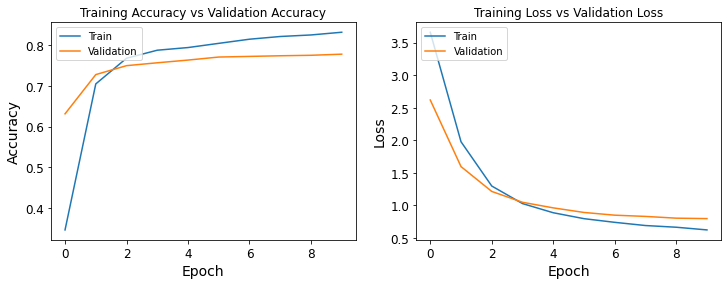

In [17]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [18]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(valid_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

80/80 [==============================] - 31s 384ms/step - loss: 0.7808 - accuracy: 0.7773
final train accuracy = 83.89 , validation accuracy = 77.73
